In [1]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt

## Load data

In [2]:
# Copy results of NF here
import subprocess

subprocess.run(["cp", "/Users/katianakontolati/PycharmProjects/pytorch-flows/results/results.npz", "data/"])
subprocess.run(["cp", "/Users/katianakontolati/Documents/Johns Hopkins University/1.PhD/LANL-Research/Research/ChemCam_data/Mixed_data/NF_mixed_train_test_data.npz", "data/"])
subprocess.run(["cp", "/Users/katianakontolati/Documents/Johns Hopkins University/1.PhD/LANL-Research/Research/ChemCam_data/calibration_data/calibration_data.npz", "data/"])

CompletedProcess(args=['cp', '/Users/katianakontolati/Documents/Johns Hopkins University/1.PhD/LANL-Research/Research/ChemCam_data/calibration_data/calibration_data.npz', 'data/'], returncode=0)

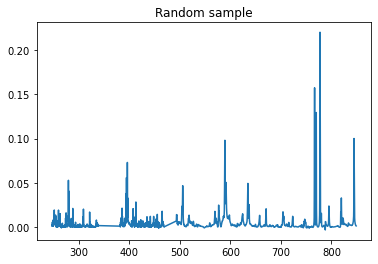

(426, 5606)

In [3]:
# Get calibration samples and labels 

# Load observations
file = np.load('data/NF_mixed_train_test_data.npz')  
calib_data = file['y_calib'] # get earth data after earth_2_mars transform

# Load wavelengths
w = file['w']
rr = np.random.randint(0,426)
plt.plot(w, calib_data[rr,:])
plt.title('Random sample')
plt.show()
calib_data.shape

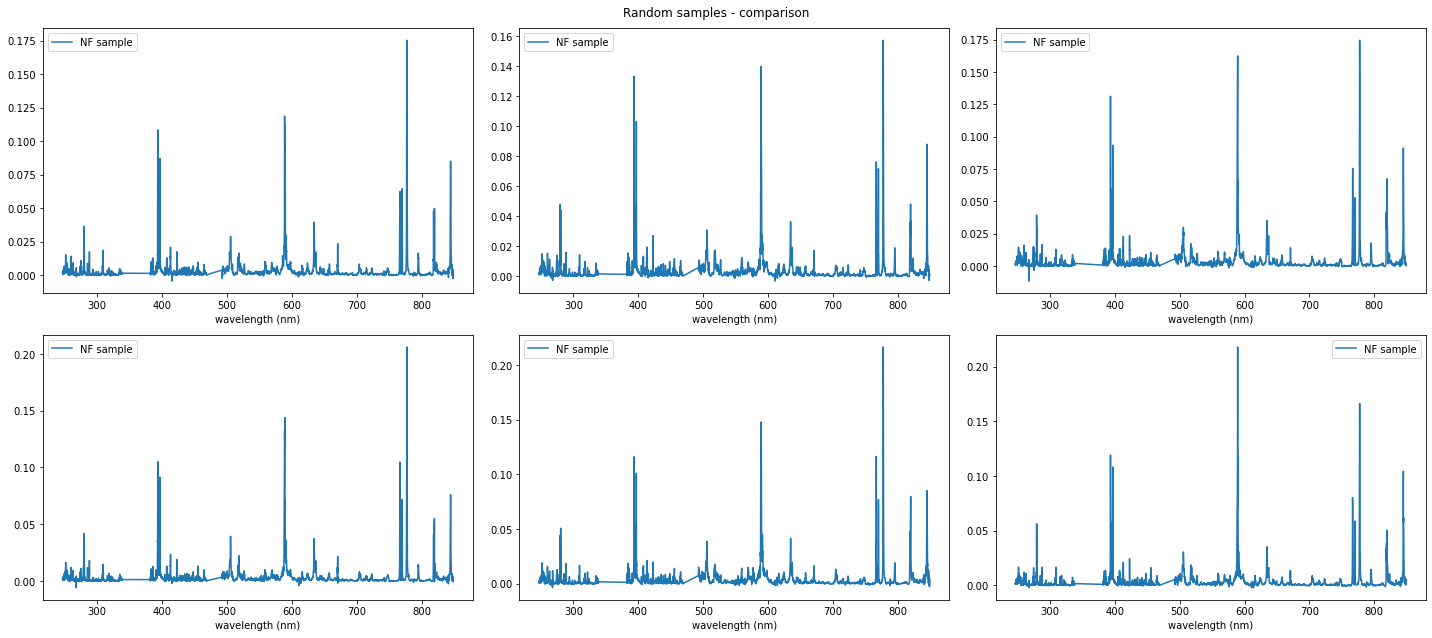

In [4]:
# Load results from NF training
file1 = np.load('data/results.npz') 
calib_data_gaussian = file1['z'] # load calibration data to gaussian (X --> Z)

# Load noise and corresponding LIBS spectra (Z --> X)
noise = file1['noise']
libs_from_noise = file1['forward_flow']

# Plot samples in two random dimensions
#plt.scatter(calib_data_gaussian[:,1], calib_data_gaussian[:,2]) # notice a few outliers
#plt.show()

# Compare an original LIBS sample with one generated with the NF model
# Plot before normalization
fig = plt.figure(figsize=(20, 9), facecolor='white')

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    rr = np.random.randint(0,400)
    #plt.plot(w, calib_data[rr,:], label='original sample')
    plt.plot(w, libs_from_noise[rr,:], label='NF sample')
    #plt.ylim(0,0.25)
    plt.legend()
    plt.xlabel('wavelength (nm)')
plt.suptitle('Random samples - comparison')
fig.tight_layout()
plt.show()

In [5]:
# Load compositions
file2 = np.load('data/calibration_data.npz')
comp = file2['c']
comp.shape

(426, 8)

## Train regressor models (one for each oxide)

In [ ]:
# Outlier detection
# from sklearn.ensemble import IsolationForest
# out = IsolationForest(random_state=1).fit(calib_data)
# ind = out.predict(calib_data)==1

In [ ]:
# throw away ouliers 
# calib_data_out = calib_data[ind]
# comp_out = comp[ind]

# calib_data = calib_data_out # save
# comp = comp_out
# print(calib_data.shape, comp.shape)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score
from tqdm import tqdm
import time

start_time = time.time()
# train 8 models, one for each oxide
# split = 400

# # # PLS
# max_comp = 50
# models_best, scores_best = [0]*comp.shape[1], [0]*comp.shape[1]
# for j in range(comp.shape[1]):
#     curr_best = 0
#     for i in range(max_comp):
#         n_comp = i+1
#         pls = PLSRegression(n_components=n_comp, max_iter=3000, tol=1e-4)
#         pls.fit(calib_data[:split], comp[:split,j])
#         score = pls.score(calib_data[split:], comp[split:,j]) # test on remaining samples
#         if score > curr_best:
#             curr_best = score
#             models_best[j] = pls
#             scores_best[j] = curr_best    
#     print(curr_best)

#NN
models_best, scores_best = [], []

for j in tqdm(range(comp.shape[1]), desc='Training of NNs'):
    
    print('Iteration: {}'.format(j+1))
    X_train, X_test, y_train, y_test = train_test_split(calib_data, comp, test_size=0.33, random_state=44, shuffle=True)

    mlp = MLPRegressor(random_state=1, max_iter=3500, activation='relu', hidden_layer_sizes=500).fit(X_train, y_train[:,j])
    score = mlp.score(X_test, y_test[:,j]) # test on remaining samples
          
    models_best.append(mlp)
    scores_best.append(score)
    print('Training of model {} completed'.format(j+1))
    print('Score:', score)
    print('')
    
print("--- Total training time - %s minutes ---" % round((time.time() - start_time)/60, 3))

In [ ]:
scores_best

In [ ]:
# Check outliers manually and remove them (for titanum and sodium)

In [ ]:
# For PLS only
#for i in range(comp.shape[1]):
#    print('# of comp. for model {}: {}'.format(i+1, models_best[i].get_params()['n_components']))

In [ ]:
oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O']
plt.figure(figsize=(7.5,4))
plt.rcParams.update({'font.size': 16})
plt.plot(oxides, scores_best)
plt.scatter(oxides, scores_best, s=50)
plt.ylabel('R2 score')
plt.xlabel('oxides')
plt.grid()
plt.title('Accuracy of NN')
plt.show()

### Plot oxide weight value vs residual (squared)

In [ ]:
fig = plt.figure(figsize=(20,9), facecolor='white')

for i in range(8):
    ax = plt.subplot(2,4,i+1)
    nn_pred = models_best[i].predict(X_test)
    res = (nn_pred - y_test[:,i])**2
    plt.scatter(y_test[:,i], res)
    plt.ylabel('residual')
    plt.xlabel('weight % oxide ({})'.format(oxides[i]))
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,9), facecolor='white')
for i in range(8):
    ax = plt.subplot(2,4,i+1)
    nn_pred = models_best[i].predict(X_test)
    rms = mean_squared_error(y_test[:,i], nn_pred, squared=False)
    
    plt.scatter(y_test[:,i], nn_pred, label='R2={}'.format(round(scores_best[i], 2)))
    plt.plot(y_test[:,i], y_test[:,i], c='r', linewidth=2)
    plt.xlabel('true')
    plt.ylabel('prediction')
    plt.legend()
    plt.annotate('{}'.format(oxides[i]), xy=(0.75, 0.05), c='g', xycoords='axes fraction')
fig.tight_layout()
plt.savefig('results/true_vs_prediction.png', dpi=400)
plt.show()

### Detect outliers manually

In [ ]:
# First outlier
nn_pred = models_best[1].predict(X_test)
plt.scatter(y_test[:,1], nn_pred, label='R2={}'.format(round(scores_best[1], 2)))
plt.show()

In [ ]:
ind1 = np.argmax(models_best[1].predict(X_test))
print(ind1)

In [ ]:
# remove outlier
X_test_new = np.delete(X_test, obj=ind1, axis=0)
y_test_new = np.delete(y_test, obj=ind1, axis=0)

In [ ]:
print(X_test_new.shape)
print(y_test_new.shape)

In [ ]:
from sklearn.metrics import mean_squared_error

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,9), facecolor='white')
for i in range(8):
    ax = plt.subplot(2,4,i+1)
    nn_pred = models_best[i].predict(X_test_new)
    #rms = mean_squared_error(y_test[:,i], nn_pred, squared=False)
    score = models_best[i].score(X_test_new, y_test_new[:,i])
    plt.scatter(y_test_new[:,i], nn_pred, label='R2={}'.format(round(score, 2)))
    plt.plot(y_test_new[:,i], y_test_new[:,i], c='r', linewidth=2)
    plt.xlabel('true')
    plt.ylabel('prediction')
    plt.legend(loc='upper left')
    plt.annotate('{}'.format(oxides[i]), xy=(0.75, 0.05), c='g', xycoords='axes fraction')
fig.tight_layout()
plt.savefig('results/true_vs_prediction-no-outliers.png', dpi=400)
plt.show()

In [ ]:
# Second outlier

nn_pred = models_best[7].predict(X_test_new)
plt.scatter(y_test_new[:,7], nn_pred, label='R2={}'.format(round(scores_best[7], 2)))
plt.show()

In [ ]:
ind2 = np.argmax(models_best[7].predict(X_test_new))
ind2

In [ ]:
# remove outlier
X_test_new = np.delete(X_test_new, obj=ind2, axis=0)
y_test_new = np.delete(y_test_new, obj=ind2, axis=0)

In [ ]:
from sklearn.metrics import mean_squared_error

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,9), facecolor='white')
save_pred = []
for i in range(8):
    ax = plt.subplot(2,4,i+1)
    nn_pred = models_best[i].predict(X_test_new)
    save_pred.append(nn_pred)
    #rms = mean_squared_error(y_test[:,i], nn_pred, squared=False)
    score = models_best[i].score(X_test_new, y_test_new[:,i])
    plt.scatter(y_test_new[:,i], nn_pred, label='R2={}'.format(round(score, 2)))
    plt.plot(y_test_new[:,i], y_test_new[:,i], c='r', linewidth=2)
    plt.xlabel('true')
    plt.ylabel('prediction')
    plt.legend(loc='upper left')
    plt.annotate('{}'.format(oxides[i]), xy=(0.75, 0.05), c='g', xycoords='axes fraction')
fig.tight_layout()
plt.savefig('results/true_vs_prediction-no-outliers.png', dpi=400)
plt.show()

In [ ]:
# # Third outlier 

# nn_pred = models_best[1].predict(X_test)
# plt.scatter(y_test[:,1], nn_pred, label='R2={}'.format(round(scores_best[1], 2)))
# plt.show()
# ind3 = np.argmax(models_best[1].predict(X_test))
# ind3

In [ ]:
# # remove outlier
# X_test = np.delete(X_test, obj=ind3, axis=0)
# y_test = np.delete(y_test, obj=ind3, axis=0)

In [ ]:
# from sklearn.metrics import mean_squared_error

# plt.rcParams.update({'font.size': 20})
# fig = plt.figure(figsize=(20,9), facecolor='white')
# for i in range(8):
#     ax = plt.subplot(2,4,i+1)
#     nn_pred = models_best[i].predict(X_test)
#     #rms = mean_squared_error(y_test[:,i], nn_pred, squared=False)
#     score = models_best[i].score(X_test, y_test[:,i])
#     plt.scatter(y_test[:,i], nn_pred, label='R2={}'.format(round(score, 2)))
#     plt.plot(y_test[:,i], y_test[:,i], c='r', linewidth=2)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     plt.legend()
#     plt.annotate('{}'.format(oxides[i]), xy=(0.75, 0.05), xycoords='axes fraction')
# fig.tight_layout()
# plt.savefig('results/true_vs_prediction-no-outliers.png', dpi=400)
# plt.show()

In [ ]:
# Check that oxides percentages add up to 100% (approx.)
plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(12,6))
save_pred_array = np.array((save_pred))
plt.ylabel('sum of percentages')
plt.xlabel('samples')
plt.plot(np.sum(comp, axis=1), label='comp. of train data')
plt.plot(np.sum(save_pred_array, axis=0), label='predicted comps with NNs')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# save data sets with no outliers
np.savez('Train-data-no-outliers.npz', x_tr=X_train, y_tr=y_train, x_te=X_test_new, y_te=y_test_new)

In [6]:
# Load test data
file10 = np.load('Train-data-no-outliers.npz')  
X_test_new = file10['x_te'] 
y_test_new = file10['y_te']
X_train= file10['x_tr'] 
y_train = file10['y_tr']

### Bootstrapping

In [56]:
# Natalie's script
# %%
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

start_time = time.time()

# %% Settings
n_boot = 100    # number of bootstrap replications
size_boot = 280 # should probably be close to y_train.shape[0]
y_ind = 1       # which oxide weight index

np.random.seed(42)

#%% Load and process data
ox_wt_names = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O']

#%% Bootstrap NN for one oxide wt
boot_preds, scores = [], []
parameters = {'n_components': np.arange(1, 15)}

for bi in tqdm(range(n_boot), desc='Bootstrap resampling'):
    # Draw bootstrap sample
    boot_ind = np.random.choice(X_train.shape[0], size=size_boot, replace=True)
    x_boot = X_train[boot_ind, :]
    y_boot = y_train[boot_ind, y_ind]
    
    # Fit model
    mlp = MLPRegressor(random_state=1, max_iter=3500, activation='relu', hidden_layer_sizes=500).fit(x_boot, y_boot)
    scores.append(mlp.score(X_test_new, y_test_new[:, y_ind])) # test on remaining samples

    # Get residuals
    resid = y_boot - mlp.predict(x_boot).squeeze()
    
    # construct PLS models for predicting residuals
    #pls_res = PLSRegression(scale=False)
    #cvres = GridSearchCV(pls_res, parameters).fit(mlp.predict(x_boot).reshape(-1, 1), resid.reshape(-1, 1)**2)
    #n_comp = cvres.best_params_['n_components']
    #print('Iteration {}: PLS component: {}'.format(bi+1, n_comp))
    pls_fit = PLSRegression(scale=False, n_components=1).fit(mlp.predict(x_boot).reshape(-1, 1), resid.reshape(-1, 1)**2)

    # TODO: as a tweak, bin residuals? or estimate heteroskedastic variance trend...?
    # some residuals much higher (for high SiO2, maybe) so could be overly conservative
    
    # Predicted squared residual
    psr = pls_fit.predict(mlp.predict(X_test_new).reshape(-1, 1))
    psr[psr<0] = 0
    
    boot_preds.append((mlp.predict(X_test_new).squeeze() + (np.random.normal(0,np.sqrt(psr))).squeeze()))
    #boot_preds.append((mlp.predict(X_test_new).squeeze() + (np.random.choice((-1, 1)) * np.sqrt(psr)).squeeze()))
    #boot_preds.append(mlp.predict(X_test_new).squeeze() + np.random.choice(resid, size=X_test_new.shape[0]))

# %%
boot_preds = np.array(boot_preds) # shape (n_boot, n_test)

print("--- Total training time - %s minutes ---" % round((time.time() - start_time)/60, 3))

Bootstrap resampling: 100%|██████████| 100/100 [1:25:37<00:00, 51.38s/it]

--- Total training time - 85.63 minutes ---


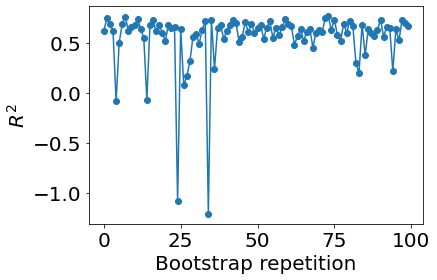

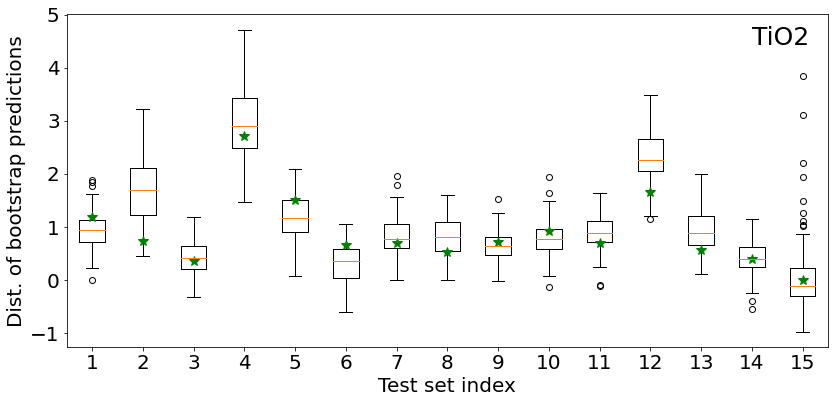

In [60]:
# %%
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(6, 4))
plt.plot(scores)
plt.scatter(np.arange(0,n_boot,1), scores)
plt.xlabel('Bootstrap repetition')
plt.ylabel(r'$R^2$')

# %%
indices = np.random.choice(boot_preds.shape[1], size=15, replace=True)
fig = plt.figure(figsize=(12, 6))
plt.boxplot(boot_preds[:,indices])
plt.plot(np.arange(1, 15+1), y_test_new[:, y_ind][indices], 'g*', markersize=10)
plt.xlabel('Test set index')
plt.ylabel('Dist. of bootstrap predictions')
#plt.title('Bootstrap NNs test predictions for %s' % ox_wt_names[y_ind])
plt.annotate('{}'.format(ox_wt_names[y_ind]), xy=(0.9, 0.91), c='k', xycoords='axes fraction', fontsize=25)
fig.tight_layout()
plt.savefig('results/bootstrapping_{}.png'.format(ox_wt_names[y_ind], dpi=400))
plt.show()
# %%

### Coverage

In [58]:
# Compute coverage
q_low, q_high = 0.025, 0.975
quant = np.quantile(boot_preds, [q_low, q_high], axis=0)

covered = 0
for i in range(boot_preds.shape[1]):
    if quant[0][i] < y_test_new[i, y_ind] < quant[1][i]:
        covered += 1
        
print('Coverage: {}%'.format(round(covered/boot_preds.shape[1] * 100, 3)))

Coverage: 97.842%


In [59]:
covered

136

## Uncertainty quantification (UQ)

### Choose nearest neighbors and compute uncertainty of predictions

In [ ]:
print(noise.shape, libs_from_noise.shape)

In [ ]:
fig = plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.scatter(noise[:,0], noise[:,1], s=15)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Noise')
plt.subplot(1,2,2)
plt.plot(w, libs_from_noise[111,:])
plt.xlabel('wavelength (nm)')
plt.ylabel('normalized intensity (a.u.)')
plt.ylim(-0.01,0.4)
plt.title('Random sample (NF)')
fig.tight_layout()
plt.show()

In [ ]:
# Choose one point and find its k-nearest neighbors
n_neighbors = 15
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors, p=2)
knn.fit(noise)

rand_sample = np.random.randint(0,noise.shape[0])
nn = knn.kneighbors(X=noise[rand_sample,:].reshape(1, -1), n_neighbors=n_neighbors, return_distance=False) # indices

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.scatter(noise[:,0], noise[:,1], s=15, label='samples')
plt.scatter(noise[rand_sample,0], noise[rand_sample,1], s=120, c='yellow', label='reference sample')
plt.scatter(noise[nn,0], noise[nn,1], s=50, c='r', label='knn')
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('knn (Euclidean distance)')
plt.legend()
plt.show()

In [ ]:
# Predict compositions for samples and its neighbors with the pretrained PLS models
pred = [] # list 
for i in range(comp.shape[1]):
    pred.append(models_best[i].predict(libs_from_noise[nn].reshape(nn.shape[1], libs_from_noise.shape[1])))

In [ ]:
pred_ar = np.array((pred)).reshape(comp.shape[1], nn.shape[1]) # convert list to numpy array
pred_ar.shape

In [ ]:
# should give ~100%
np.sum(pred_ar, axis=0)

In [ ]:
# Compute mean and max-min
mean = np.mean(pred_ar, axis=1)
p_max = np.amax(pred_ar, axis=1)
p_min = np.amin(pred_ar, axis=1)
std = np.std(pred_ar, axis=1)

In [ ]:
# Plot distributions of predictions
plt.rcParams.update({'font.size': 17})

plt.figure(figsize=(8,5))
plt.plot(oxides, mean, label=r'$\mu$')
plt.scatter(oxides, mean, c='r', s=60)
plt.fill_between(oxides, p_min, p_max, alpha=0.2, label=r'$\pm 2\sigma$')
plt.errorbar(oxides, mean, yerr=2*std, fmt='.k')
#plt.errorbar(oxides, mean, yerr=p_min + p_max, fmt='-o')
plt.title('Prediction (nn={})'.format(n_neighbors))
plt.xlabel('oxides')
plt.ylabel('percentage')
plt.legend()
plt.grid()
plt.savefig('results/prediction_knn_{}.png'.format(n_neighbors), dpi=300)
plt.show()

In [ ]:
# Check variance in calibration data

mean_cal = np.mean(comp, axis=0)
min_cal = np.amin(comp, axis=0)
max_cal = np.amax(comp, axis=0)


plt.figure(figsize=(7,5))
plt.plot(oxides, mean_cal, label=r'$\mu$')
plt.scatter(oxides, mean_cal, c='r', s=60)
plt.fill_between(oxides, min_cal, max_cal, alpha=0.2, label='min to max')
#plt.errorbar(oxides, mean_cal, yerr=2*std_cal, fmt='.k')
#plt.errorbar(oxides, mean, yerr=p_min + p_max, fmt='-o')
plt.xlabel('oxides')
plt.ylabel('percentage')
plt.legend()
plt.grid()

## Independent component analysis and normalizing flows in spectral latent space

In [7]:
data_for_ica = file['y_train']
data_for_ica.shape

(626, 5606)

In [8]:
from sklearn.decomposition import FastICA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

parameters = {'n_components': np.arange(5, 16)}
r2 = []
for i in parameters['n_components']:
    ica = FastICA(n_components=i, random_state=0).fit(data_for_ica)
    transf = ica.transform(data_for_ica)
    recon = ica.inverse_transform(transf)
    r2.append(r2_score(data_for_ica, recon))

In [9]:
print('best accuracy is: {} for {} components'.format(round(np.amax(r2),3), parameters['n_components'][np.argmax(r2)]))

best accuracy is: 0.829 for 15 components


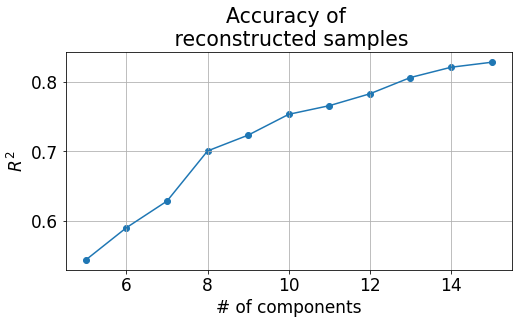

In [10]:
plt.rcParams.update({'font.size': 17})
plt.figure(figsize=(8,4))
plt.plot(parameters['n_components'], r2)
plt.scatter(parameters['n_components'], r2)
plt.ylabel(r'$R^2$')
plt.xlabel('# of components')
plt.title('Accuracy of \n reconstructed samples')
plt.grid()
plt.show()

Text(0.5, 0, 'ICA comp. 6')

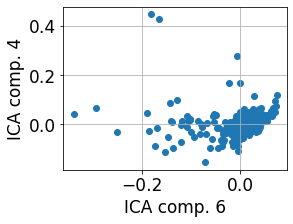

In [11]:
plt.figure(figsize=(4,3))
plt.scatter(transf[:,3], transf[:,5])
plt.ylabel('ICA comp. 4')
plt.grid()
plt.xlabel('ICA comp. 6')

In [12]:
np.savez('data/ica_samples.npz', ica=transf)
# Copy this sample to the NF code directory
subprocess.run(["cp", "data/ica_samples.npz", "/Users/katianakontolati/PycharmProjects/pytorch-flows/data/chemcam/"])

CompletedProcess(args=['cp', 'data/ica_samples.npz', '/Users/katianakontolati/PycharmProjects/pytorch-flows/data/chemcam/'], returncode=0)

### Train NF model in pycharm (pytorch-flows package)

In [13]:
# Get results from trained NF model
subprocess.run(["cp", "/Users/katianakontolati/PycharmProjects/pytorch-flows/results/results_ica.npz", "data/"])

CompletedProcess(args=['cp', '/Users/katianakontolati/PycharmProjects/pytorch-flows/results/results_ica.npz', 'data/'], returncode=0)

In [14]:
ica_file = np.load('data/results_ica.npz')  
noise_ica = ica_file['noise'] 
samples_ica = ica_file['forward_flow'] # get actual samples from NF model

In [15]:
# Check NF samples with ICA inverse map
nf_samples_inv_ica = ica.inverse_transform(samples_ica)
nf_samples_inv_ica.shape

(2000, 5606)

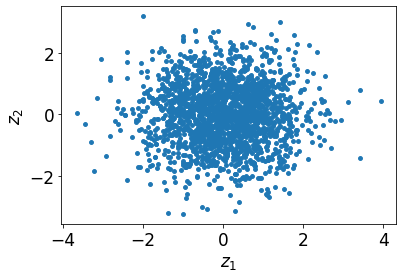

In [16]:
# Plot noise
plt.scatter(noise_ica[:,0], noise_ica[:,1], s=15)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.show()

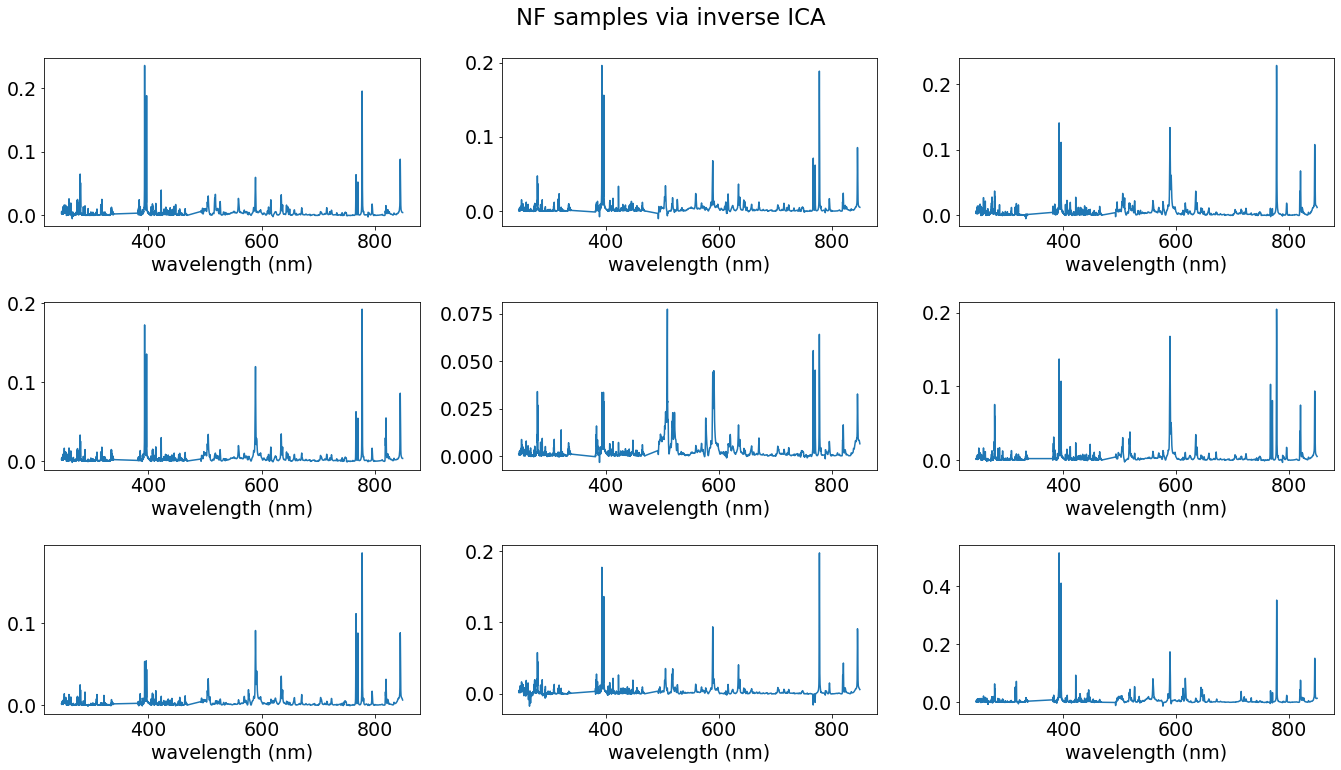

In [17]:
# Plot random samples
plt.rcParams.update({'font.size': 19})
fig = plt.figure(figsize=(19, 11), facecolor='white')

for i in range(9):
    ax = plt.subplot(3,3,i+1)
    rr = np.random.randint(0,nf_samples_inv_ica.shape[0]-1)
    plt.plot(w, nf_samples_inv_ica[rr,:], label='NF sample')
    #plt.ylim(0,0.25)
    #plt.legend()
    plt.xlabel('wavelength (nm)')
plt.suptitle('NF samples via inverse ICA')
fig.tight_layout()
plt.show()

In [18]:
# Predict compositions for generated samples
comp_pred_ica = []
for i in range(8):
    nn_pred = models_best[i].predict(nf_samples_inv_ica)
    comp_pred_ica.append(nn_pred)
    
comp_pred_ica_array = np.array(comp_pred_ica)

NameError: name 'models_best' is not defined

In [ ]:
fig = plt.figure(figsize=(10, 5), facecolor='white')
plt.scatter(np.arange(0,2000), np.sum(comp_pred_ica_array, axis=0))
plt.plot(np.arange(0,2000), np.ones(2000)*100, c='r')
plt.ylim(0,140)
plt.ylabel('sum of percentages')
plt.xlabel('sample index')
plt.show()

In [ ]:
mean_ica = np.mean(comp_pred_ica_array, axis=1)
std_ica = np.std(comp_pred_ica_array, axis=1)
min_ica = np.amin(comp_pred_ica_array, axis=1)
max_ica = np.amax(comp_pred_ica_array, axis=1)

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(oxides, mean_ica, label=r'$\mu$')
plt.scatter(oxides, mean_ica, c='r', s=60)
plt.fill_between(oxides, min_ica, max_ica, alpha=0.2, label='min to max')
plt.xlabel('oxides')
plt.ylabel('percentage')
plt.legend()
plt.grid()

In [37]:
nf_test = nf_samples_inv_ica[:1000,:]

In [38]:
# Bootstrap for NF generated samples
# %%
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

start_time = time.time()

# %% Settings
n_boot = 100    # number of bootstrap replications
size_boot = 280 # should probably be close to y_train.shape[0]
y_ind = 0       # which oxide weight index

np.random.seed(42)

#%% Load and process data
ox_wt_names = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O']

#%% Bootstrap NN for one oxide wt
boot_preds, scores = [], []
parameters = {'n_components': np.arange(1, 15)}

for bi in tqdm(range(n_boot), desc='Bootstrap resampling'):
    # Draw bootstrap sample
    boot_ind = np.random.choice(X_train.shape[0], size=size_boot, replace=True)
    x_boot = X_train[boot_ind, :]
    y_boot = y_train[boot_ind, y_ind]
    
    # Fit model
    mlp = MLPRegressor(random_state=1, max_iter=3500, activation='relu', hidden_layer_sizes=500).fit(x_boot, y_boot)
    scores.append(mlp.score(X_test_new, y_test_new[:, y_ind])) # test on remaining samples

    # Get residuals
    resid = y_boot - mlp.predict(x_boot).squeeze()

    # Fit model to map predictions to squared residuals
    pls_fit = PLSRegression(scale=False, n_components=1).fit(mlp.predict(x_boot).reshape(-1, 1), resid.reshape(-1, 1)**2)

    # Predicted squared residual
    psr = pls_fit.predict(mlp.predict(nf_test).reshape(-1, 1))
    psr[psr<0] = 0
    boot_preds.append((mlp.predict(nf_test).squeeze() + (np.random.normal(0,np.sqrt(psr))).squeeze()))
    #boot_preds.append((mlp.predict(nf_test).squeeze() + (np.random.choice((-2, -1, 1, 2)) * np.sqrt(psr)).squeeze()))
    #boot_preds.append(mlp.predict(nf_test).squeeze() + np.random.choice(resid, size=nf_test.shape[0]))

# %%
boot_preds = np.array(boot_preds) # shape (n_boot, n_test)

print("--- Total training time - %s minutes ---" % round((time.time() - start_time)/60, 3))

Bootstrap resampling: 100%|██████████| 100/100 [7:23:17<00:00, 265.97s/it] 

--- Total training time - 443.287 minutes ---


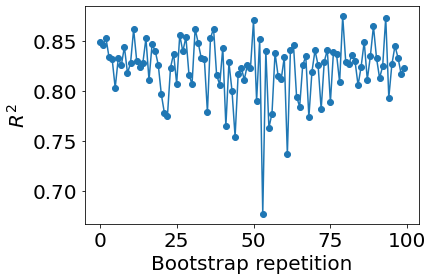

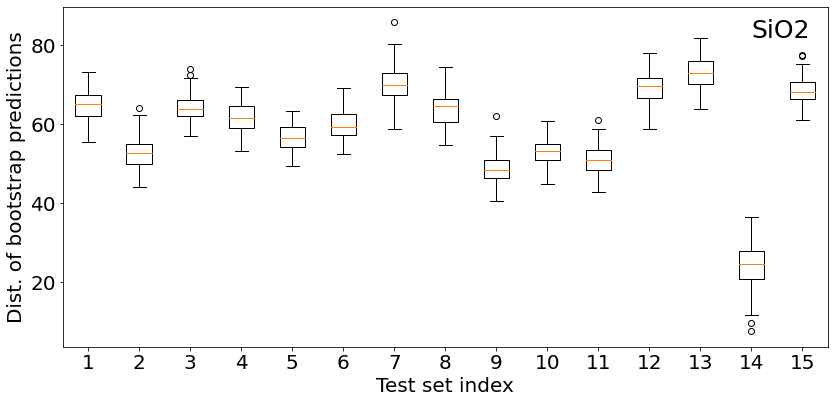

In [40]:
# %%
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(6, 4))
plt.plot(scores)
plt.scatter(np.arange(0,n_boot,1), scores)
plt.xlabel('Bootstrap repetition')
plt.ylabel(r'$R^2$')

# %%
indices = np.random.choice(boot_preds.shape[1], size=15, replace=True)
fig = plt.figure(figsize=(12, 6))
plt.boxplot(boot_preds[:,indices])
plt.xlabel('Test set index')
plt.ylabel('Dist. of bootstrap predictions')
#plt.title('Bootstrap NNs test predictions for %s' % ox_wt_names[y_ind])
#plt.ylim(-0.5,5)
plt.annotate('{}'.format(ox_wt_names[y_ind]), xy=(0.9, 0.91), c='k', xycoords='axes fraction', fontsize=25)
fig.tight_layout()
plt.savefig('results/bootstrapping_for_NF_samples_{}.png'.format(ox_wt_names[y_ind], dpi=400))
plt.show()
# %%

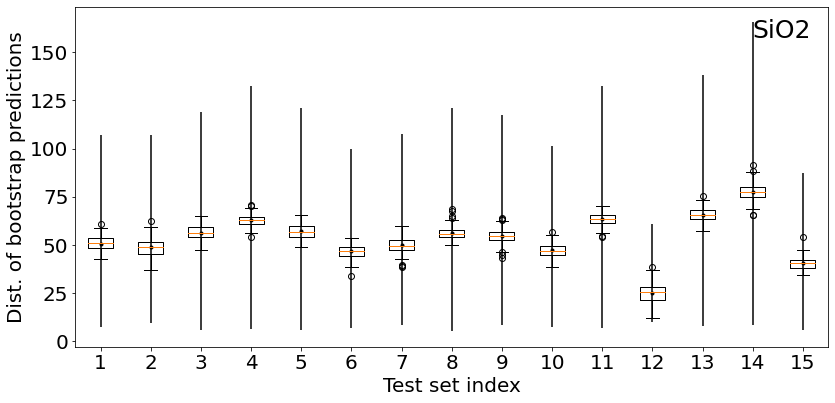

In [55]:
# try plot with errorbars for 95% CI instead of 50%
q_low, q_high = 0.025, 0.975
quant = np.quantile(boot_preds, [q_low, q_high], axis=0)
mean_boot = np.mean(boot_preds, axis=0)

# try

indices = np.random.choice(boot_preds.shape[1], size=15, replace=True)
fig = plt.figure(figsize=(12, 6))
plt.errorbar(x=np.arange(1,16,1), y=mean_boot[indices], yerr=quant[:,indices], fmt='.k');
plt.boxplot(boot_preds[:,indices])
plt.xlabel('Test set index')
plt.ylabel('Dist. of bootstrap predictions')
#plt.title('Bootstrap NNs test predictions for %s' % ox_wt_names[y_ind])
#plt.ylim(-0.5,5)
plt.annotate('{}'.format(ox_wt_names[y_ind]), xy=(0.9, 0.91), c='k', xycoords='axes fraction', fontsize=25)
fig.tight_layout()
plt.show()
# %%